In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import fashion_mnist
import time
import pickle

In [4]:
import wandb
wandb.login()
#API Key: f659082c2b19bf3ffaaceceb36c1e280541f6b11

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yeshu183 (yeshu183-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [6]:
# Split validation set (10% of training data)
val_size = int(0.1 * len(x_train))
x_val, y_val = x_train[:val_size], y_train[:val_size]
x_train, y_train = x_train[val_size:], y_train[val_size:]

# Normalize inputs
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_val = x_val.reshape(x_val.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

In [5]:
y_train

array([8, 6, 4, ..., 3, 0, 5], dtype=uint8)

In [7]:
class Optimizers:
    def __init__(self, lr=1e-3, epsilon=1e-8, beta1=0.9, beta2=0.999, rho=0.9, optimizer="adam"):
        self.lr = lr
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        self.rho = rho
        self.optimizer = optimizer  # Store optimizer type

        self.v, self.s, self.m = {}, {}, {}  # Optimizer state
        self.t = 0  # Time step for Adam/Nadam

    def _initialize_params(self, key, shape):
        """Initialize optimizer states for a given parameter key"""
        if key not in self.v:
            self.v[key] = np.zeros(shape)
            self.s[key] = np.zeros(shape)
            self.m[key] = np.zeros(shape)

    def step(self, w, b, dw, db, key="w"):
        """Generic function to perform an optimization step based on selected optimizer"""
        self._initialize_params(key, w.shape)
        self.t += 1  # Increment time step

        if self.optimizer == "sgd":
            w -= self.lr * dw
            b -= self.lr * db

        elif self.optimizer == "momentum":
            self.v[key] = self.beta1 * self.v[key] - self.lr * dw
            w += self.v[key]
            b -= self.lr * db

        elif self.optimizer == "nesterov":
            prev_v = self.v[key]
            self.v[key] = self.beta1 * self.v[key] - self.lr * dw
            w += -self.beta1 * prev_v + (1 + self.beta1) * self.v[key]
            b -= self.lr * db

        elif self.optimizer == "rmsprop":
            self.s[key] = self.rho * self.s[key] + (1 - self.rho) * (dw ** 2)
            w -= self.lr * dw / (np.sqrt(self.s[key]) + self.epsilon)
            b -= self.lr * db

        elif self.optimizer == "adam":
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * dw
            self.s[key] = self.beta2 * self.s[key] + (1 - self.beta2) * (dw ** 2)
            m_hat = self.m[key] / (1 - self.beta1 ** self.t)
            s_hat = self.s[key] / (1 - self.beta2 ** self.t)
            w -= self.lr * m_hat / (np.sqrt(s_hat) + self.epsilon)
            b -= self.lr * db

        return w, b

In [23]:
class NN:
  def __init__(self,input_shape,output_shape,n_hidden_layers,h_per_layer,optimizer,activation_func="relu",loss_func="cross_entropy_loss",init_type="random",l2_reg=0):
    self.input_shape = input_shape
    self.output_shape = output_shape
    self.n_h = n_hidden_layers
    self.k = h_per_layer
    self.weights,self.biases = self.weight_init(init_type)
    self.optimizer_function = optimizer
    self.grad_weights = [0]*(self.n_h+1)
    self.grad_biases = [0]*(self.n_h+1)
    self.activation_func = activation_func
    self.loss_func = loss_func
    self.l2_reg = l2_reg
  def activation(self,x):
    if self.activation_func == "relu":
      return np.maximum(0,x)
    elif self.activation_func == "tanh":
      return np.tanh(x)
    elif self.activation_func == "sigmoid":
      return 1/(1+np.exp(-x))
  def activation_grad(self,x):
    if self.activation_func == "relu":
      return np.where(x>0,1,0)
    elif self.activation_func == "tanh":
      return 1-np.tanh(x)**2
    elif self.activation_func == "sigmoid":
      s = 1/(1+np.exp(-x))
      return s*(1-s)
  def softmax(self,x):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)
  def one_hot(self,y):
    ohe = np.zeros((len(y), self.output_shape))
    for i in range(len(y)):
      ohe[i][y[i]] = 1
    return ohe
  def loss(self,y_hat,y_true):
    if self.loss_func == "cross_entropy_loss":
      y_hat = np.array(y_hat)
      y_true = np.array(y_true)
      epsilon = 1e-10  # Prevent log(0)
      return -np.sum(y_true * np.log(y_hat + epsilon)) / y_hat.shape[0]
    elif self.loss_func == "squared_error":
      diff = y_hat - y_true
      squared_diff = diff**2
      mse = np.mean(squared_diff)
      return mse
  def accuracy(self,y_hat,y_true):
    return np.sum(y_hat==y_true)/len(y_true)
  def weight_init(self, init_type="random"):
    weights = []
    biases = []
    if init_type == "random":
        weights.append(np.random.randn(self.input_shape, self.k))
        biases.append(np.random.randn(self.k, 1))
        for i in range(self.n_h - 1):
            weights.append(np.random.randn(self.k, self.k))
            biases.append(np.random.randn(self.k, 1))
        weights.append(np.random.randn(self.k, self.output_shape))
        biases.append(np.random.randn(self.output_shape, 1))
    elif init_type == "xavier":
        # Xavier Initialization
        weights.append(np.random.randn(self.input_shape, self.k) * np.sqrt(2 / (self.input_shape + self.k)))
        biases.append(np.zeros((self.k, 1)))  # Biases are usually initialized to 0
        for i in range(self.n_h - 1):
            weights.append(np.random.randn(self.k, self.k) * np.sqrt(2 / (self.k + self.k)))
            biases.append(np.zeros((self.k, 1)))
        weights.append(np.random.randn(self.k, self.output_shape) * np.sqrt(2 / (self.k + self.output_shape)))
        biases.append(np.zeros((self.output_shape, 1)))
    return weights, biases

  def update_parameters(self):
    for i in range(len(self.weights)):
      grad_w = np.array(self.grad_weights[i])
      grad_b = np.array(self.grad_biases[i])
      self.weights[i], self.biases[i] = self.optimizer_function.step(
              self.weights[i], self.biases[i],grad_w,grad_b,key=f"layer_{i}")

  def forward(self,x):
    a_list = [0]*(self.n_h+2)
    h_list = [0]*(self.n_h+2)
    h = x.T
    h_list[0] = h
    for i in range(self.n_h):
      a_list[i+1] = np.dot(self.weights[i].T,h_list[i])+self.biases[i] #biases are broadcasted
      h_list[i+1] = self.activation(a_list[i+1])
    a_list[self.n_h+1] = np.dot(self.weights[self.n_h].T,h_list[self.n_h])+self.biases[self.n_h]
    y_hat = self.softmax(a_list[self.n_h+1]).T
    h_list[self.n_h+1] = y_hat
    return a_list,h_list
  def backward(self,a_list,h_list,y):
    a_grad_list = [0]*(self.n_h+2)
    h_grad_list = [0]*(self.n_h+2)
    y_hat = h_list[self.n_h+1]
    if self.loss_func == "cross_entropy_loss": #gradient wrt output layer
      a_grad = (y_hat - self.one_hot(y)).T
    elif self.loss_func == "squared_error":
      #a_grad = (y_hat - self.one_hot(y)).T
      a_grad = (2*(y_hat - self.one_hot(y))*y_hat*(1-y_hat)).T #must be changed appropriately
    a_grad_list[-1] = a_grad/y_hat.shape[0]
    for k in range(self.n_h,-1,-1): # gradient wrt hiddden layers
      h_grad = np.dot(self.weights[k],a_grad_list[k+1])
      h_grad_list[k] = h_grad
      a_grad = np.multiply(h_grad,self.activation_grad(a_list[k]))
      a_grad_list[k] = a_grad
      self.grad_weights[k] = np.dot(a_grad_list[k+1],h_list[k].T).T + + self.l2_reg * self.weights[k] #gradients wrt parameters
      self.grad_biases[k] = np.sum(a_grad_list[k+1],axis=1, keepdims=True)
  def predict(self,x):
    a_list,h_list = self.forward(x)
    return np.argmax(h_list[self.n_h+1],axis=0)
  def train(self,x_train,y_train,x_val,y_val,epochs=10,batch_size=32):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    for i in range(epochs):
      start = time.time()
      indices = np.arange(len(x_train))
      np.random.shuffle(indices)
      per_epoch_loss = []
      per_epoch_acc = []
      for j in range(0,len(x_train),batch_size):
        #startf = time.time()
        batch_indices = indices[j:j+batch_size]
        x_batch = x_train[batch_indices]
        y_batch = y_train[batch_indices]
        a_list_train,h_list_train = self.forward(x_batch) # forward pass
        #end_time_f = time.time()
        #startb = time.time()
        #print("forward pass done")
        self.backward(a_list_train,h_list_train,y_batch) # backward pass
        #end_time_b = time.time()
        #starto = time.time()
        #print("backward pass done")
        self.update_parameters()
        #self.optimizer_function(lr=lr) # updating weights
        #end_time_o = time.time()
        #print("optimizer done")
        y_hat = h_list_train[self.n_h+1]
        per_epoch_loss.append(self.loss(y_hat,self.one_hot(y_batch)))
        per_epoch_acc.append(self.accuracy(np.argmax(np.array(y_hat),axis=1),y_batch))
      train_loss = np.mean(per_epoch_loss)
      train_acc = np.mean(per_epoch_acc)
      train_loss_list.append(train_loss)
      train_acc_list.append(train_acc)
      #print(f"Epoch: {i+1} | Batch: {j+1}/{len(x_train)} | f_time: {(end_time_f-startf): .6f} | b_time:{(end_time_b-startb): .6f} | o_time:{(end_time_o-starto): .6f}")
      #print("Train Loss: ",train_loss,"Train Accuracy: ",train_acc)
      a_list_val,h_list_val = self.forward(x_val)
      y_hat_val = h_list_val[self.n_h+1]
      val_loss = self.loss(y_hat_val,self.one_hot(y_val))
      val_acc = self.accuracy(np.argmax(np.array(y_hat_val),axis=1),y_val)
      val_loss_list.append(val_loss)
      val_acc_list.append(val_acc)
      end = time.time()
      # Log metrics
      wandb.log({
          "train_loss": train_loss,
          "train_acc": train_acc,
          "val_loss": val_loss,
          "val_acc": val_acc,
          "epoch": i+1
      })
      print(f"Epoch: {i+1} | Time: {(end-start):.2f} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")
    return train_loss_list,train_acc_list,val_loss_list,val_acc_list

In [24]:
wandb.finish()
wandb.init(project="Example_run")
# Hyperparameters
num_hid_layers = 3 #3,4,5
hid_layer_size = 64  # Changeable number of layers
weight_init = 'xavier'  # Options: 'random', 'xavier'
activation = 'relu'  # Options: 'sigmoid', 'tanh', 'relu'
l2_reg = 0.05  # L2 regularization strength
lr = 1e-3  # Options: 1e-3, 1e-4
batch_size = 64  # Options: 16, 32, 64
epochs = 3  # Options: 5, 10
optimizer_func = 'sgd'  # Options: 'sgd', 'momentum', 'nesterov', 'rmsprop', 'adam'
loss_func = "squared_error"  # Options: 'cross_entropy_loss', 'squared_error'
# self,input_shape,output_shape,n_hidden_layers,h_per_layer,activation_func="ReLU",loss_func="cross_entropy_loss"
# Initialize and train the model
optimizer = Optimizers(lr=lr, beta1=0.9, beta2=0.999, rho=0.9, optimizer=optimizer_func)
nn = NN(input_shape=784,output_shape=10,n_hidden_layers=num_hid_layers, h_per_layer=hid_layer_size, activation_func=activation, init_type=weight_init, loss_func=loss_func,l2_reg=l2_reg,optimizer=optimizer)
train_loss_list,train_acc_list,val_loss_list,val_acc_list = nn.train(x_train, y_train, x_val, y_val, epochs=epochs,batch_size=batch_size)
wandb.finish()

Epoch: 1 | Time: 4.85 | Train Loss: 0.0896 | Train Accuracy: 0.1234 | Val Loss: 0.0887 | Val Accuracy: 0.1583
Epoch: 2 | Time: 2.98 | Train Loss: 0.0881 | Train Accuracy: 0.1972 | Val Loss: 0.0875 | Val Accuracy: 0.2353
Epoch: 3 | Time: 2.59 | Train Loss: 0.0871 | Train Accuracy: 0.2588 | Val Loss: 0.0865 | Val Accuracy: 0.2980


epoch,▁▅█
train_acc,▁▅█
train_loss,█▄▁
val_acc,▁▅█
val_loss,█▄▁
epoch,3
train_acc,0.25881
train_loss,0.08712
val_acc,0.298
val_loss,0.08653


In [ ]:
# Initialize Weights & Biases (wandb)
wandb.finish()
best_val_acc = 0

# nn = NN(input_shape=784,output_shape=10,n_hidden_layers=num_hid_layers, h_per_layer=hid_layer_size, activation_func=activation, init_type=weight_init, loss_func=loss_func,l2_reg=l2_reg)
# train_loss_list,train_acc_list,val_loss_list,val_acc_list = nn.train(x_train, y_train, x_val, y_val, epochs=epochs,lr=lr,batch_size=batch_size)

# Define sweep configuration
sweep_config = {
    'method': 'bayes',  # Options: grid, random, bayes
    'metric': {'name': 'final_val_acc', 'goal': 'maximize'},
    'parameters': {
        'loss_func': {'values': ['cross_entropy_loss','squared_error']},#, 'squared_error'
        'epochs': {'values': [5,10]},
        'num_hid_layers': {'values': [3, 4, 5]},
        'hid_layer_size': {'values': [32,64,128]},
        'lr': {'values': [1e-3, 1e-4]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']},
        'l2_reg': {'values': [0, 0.0005, 0.5]},
        'batch_size': {'values': [16, 32, 64]},
        'optimizer_func': {'values': ['sgd','momentum', 'nesterov', 'rmsprop', 'adam']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="New Sweep")

def train_sweep():
    global best_val_acc
    wandb.init(project="New Sweep")
    config = wandb.config
    wandb.run.name = f"e_{config.epochs}_hl_{config.num_hid_layers}_nhpl_{config.hid_layer_size}_bs_{config.batch_size}_init_{config.weight_init}_ac_{config.activation}_op_{config.optimizer_func}_lo_{config.loss_func}"
    optimizer = Optimizers(lr=config.lr, beta1=0.9, beta2=0.999, rho=0.9, optimizer=config.optimizer_func)
    nn = NN(
        input_shape=784,
        n_hidden_layers=config.num_hid_layers,
        h_per_layer=config.hid_layer_size,
        activation_func=config.activation,
        init_type=config.weight_init,
        l2_reg=config.l2_reg,
        optimizer=optimizer,
        loss_func=config.loss_func,
        output_shape=10
    )

    train_loss_list,train_acc_list,val_loss_list,val_acc_list = nn.train(x_train, y_train, x_val, y_val, epochs=config.epochs, batch_size=config.batch_size)

    a_list_val,h_list_val = nn.forward(x_val)
    y_hat_val = h_list_val[nn.n_h+1]
    final_val_loss = nn.loss(y_hat_val,nn.one_hot(y_val))
    final_val_acc = nn.accuracy(np.argmax(np.array(y_hat_val),axis=1),y_val)
    wandb.log({"train_loss": train_loss_list})
    wandb.log({"train_acc": train_acc_list})
    wandb.log({"val_loss": val_loss_list})
    wandb.log({"val_acc": val_acc_list})
    wandb.log({"final_val_loss": final_val_loss})
    wandb.log({"final_val_acc": final_val_acc})
    print(f"Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_acc:.4f}")
    if final_val_acc > best_val_acc:
        best_val_acc = final_val_acc
        with open("best_model.pkl", "wb") as f:
            pickle.dump(nn, f)  # Save the entire model object
        wandb.save("best_model.pkl")  # Save to W&B cloud storage
        print("Best model updated!")

wandb.agent(sweep_id, function=train_sweep,count=100)
wandb.finish()

Create sweep with ID: surnww5r
Sweep URL: https://wandb.ai/yeshu183-indian-institute-of-technology-madras/New%20Sweep/sweeps/surnww5r


wandb: Agent Starting Run: 2layq9u9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hid_layer_size: 32
wandb: 	l2_reg: 0.0005
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: nesterov
wandb: 	weight_init: xavier


Epoch: 1 | Time: 3.96 | Train Loss: 2.3090 | Train Accuracy: 0.0977 | Val Loss: 2.3031 | Val Accuracy: 0.1003
Epoch: 2 | Time: 5.52 | Train Loss: 2.3024 | Train Accuracy: 0.1062 | Val Loss: 2.3023 | Val Accuracy: 0.1003
Epoch: 3 | Time: 3.31 | Train Loss: 2.3023 | Train Accuracy: 0.1048 | Val Loss: 2.3022 | Val Accuracy: 0.0990
Epoch: 4 | Time: 3.30 | Train Loss: 2.3017 | Train Accuracy: 0.1066 | Val Loss: 2.3022 | Val Accuracy: 0.1013
Epoch: 5 | Time: 6.17 | Train Loss: 2.3013 | Train Accuracy: 0.1125 | Val Loss: 2.3009 | Val Accuracy: 0.0990
Validation Loss: 2.3009, Validation Accuracy: 0.0990
Best model updated!


epoch,▁▃▅▆█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▄▅█
train_loss,█▂▂▁▁
val_acc,▅▅▁█▁
val_loss,█▆▅▅▁
epoch,5
final_val_acc,0.099
final_val_loss,2.30095


wandb: Agent Starting Run: di2trkzx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0.0005
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: rmsprop
wandb: 	weight_init: xavier


Epoch: 1 | Time: 8.13 | Train Loss: 0.5354 | Train Accuracy: 0.8055 | Val Loss: 0.4698 | Val Accuracy: 0.8225
Epoch: 2 | Time: 5.55 | Train Loss: 0.4073 | Train Accuracy: 0.8533 | Val Loss: 0.4318 | Val Accuracy: 0.8395
Epoch: 3 | Time: 7.77 | Train Loss: 0.3755 | Train Accuracy: 0.8624 | Val Loss: 0.3777 | Val Accuracy: 0.8605
Epoch: 4 | Time: 5.92 | Train Loss: 0.3538 | Train Accuracy: 0.8698 | Val Loss: 0.3740 | Val Accuracy: 0.8633
Epoch: 5 | Time: 8.19 | Train Loss: 0.3430 | Train Accuracy: 0.8736 | Val Loss: 0.3506 | Val Accuracy: 0.8715
Validation Loss: 0.3506, Validation Accuracy: 0.8715
Best model updated!


epoch,▁▃▅▆█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▃▆▇█
val_loss,█▆▃▂▁
epoch,5
final_val_acc,0.8715
final_val_loss,0.35057


wandb: Agent Starting Run: pjglc4oe with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0.5
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 3
wandb: 	optimizer_func: nesterov
wandb: 	weight_init: random


Epoch: 1 | Time: 12.25 | Train Loss: 2.4344 | Train Accuracy: 0.1251 | Val Loss: 2.3071 | Val Accuracy: 0.1028
Epoch: 2 | Time: 12.54 | Train Loss: 2.3083 | Train Accuracy: 0.0989 | Val Loss: 2.3052 | Val Accuracy: 0.1013
Epoch: 3 | Time: 10.60 | Train Loss: 2.3084 | Train Accuracy: 0.0992 | Val Loss: 2.3064 | Val Accuracy: 0.1013
Epoch: 4 | Time: 10.88 | Train Loss: 2.3080 | Train Accuracy: 0.1019 | Val Loss: 2.3084 | Val Accuracy: 0.1013
Epoch: 5 | Time: 12.06 | Train Loss: 2.3077 | Train Accuracy: 0.1021 | Val Loss: 2.3053 | Val Accuracy: 0.0983
Validation Loss: 2.3053, Validation Accuracy: 0.0983


epoch,▁▃▅▆█
final_val_acc,▁
final_val_loss,▁
train_acc,█▁▁▂▂
train_loss,█▁▁▁▁
val_acc,█▆▆▆▁
val_loss,▅▁▄█▁
epoch,5
final_val_acc,0.09833
final_val_loss,2.30535


wandb: Agent Starting Run: bwl1a6qn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0.0005
wandb: 	loss_func: squared_error
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: momentum
wandb: 	weight_init: xavier


Epoch: 1 | Time: 4.62 | Train Loss: 0.0894 | Train Accuracy: 0.1639 | Val Loss: 0.0882 | Val Accuracy: 0.2365
Epoch: 2 | Time: 5.36 | Train Loss: 0.0867 | Train Accuracy: 0.2582 | Val Loss: 0.0850 | Val Accuracy: 0.2545
Epoch: 3 | Time: 7.02 | Train Loss: 0.0818 | Train Accuracy: 0.2700 | Val Loss: 0.0786 | Val Accuracy: 0.2767
Epoch: 4 | Time: 4.61 | Train Loss: 0.0745 | Train Accuracy: 0.3192 | Val Loss: 0.0707 | Val Accuracy: 0.3735
Epoch: 5 | Time: 8.14 | Train Loss: 0.0653 | Train Accuracy: 0.4954 | Val Loss: 0.0584 | Val Accuracy: 0.6163
Validation Loss: 0.0584, Validation Accuracy: 0.6163


epoch,▁▃▅▆█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▃▃▄█
train_loss,█▇▆▄▁
val_acc,▁▁▂▄█
val_loss,█▇▆▄▁
epoch,5
final_val_acc,0.61633
final_val_loss,0.05835


wandb: Agent Starting Run: t6h0pzj2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0
wandb: 	loss_func: squared_error
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 15.64 | Train Loss: 0.0286 | Train Accuracy: 0.8007 | Val Loss: 0.0220 | Val Accuracy: 0.8460
Epoch: 2 | Time: 15.74 | Train Loss: 0.0216 | Train Accuracy: 0.8500 | Val Loss: 0.0201 | Val Accuracy: 0.8588
Epoch: 3 | Time: 15.65 | Train Loss: 0.0198 | Train Accuracy: 0.8627 | Val Loss: 0.0192 | Val Accuracy: 0.8647
Epoch: 4 | Time: 16.11 | Train Loss: 0.0187 | Train Accuracy: 0.8723 | Val Loss: 0.0186 | Val Accuracy: 0.8678
Epoch: 5 | Time: 16.48 | Train Loss: 0.0179 | Train Accuracy: 0.8765 | Val Loss: 0.0181 | Val Accuracy: 0.8708
Epoch: 6 | Time: 16.44 | Train Loss: 0.0173 | Train Accuracy: 0.8816 | Val Loss: 0.0183 | Val Accuracy: 0.8733
Epoch: 7 | Time: 15.64 | Train Loss: 0.0169 | Train Accuracy: 0.8839 | Val Loss: 0.0177 | Val Accuracy: 0.8762
Epoch: 8 | Time: 15.18 | Train Loss: 0.0163 | Train Accuracy: 0.8895 | Val Loss: 0.0176 | Val Accuracy: 0.8777
Epoch: 9 | Time: 15.42 | Train Loss: 0.0160 | Train Accuracy: 0.8910 | Val Loss: 0.0173 | Val Accuracy: 0.8773
E

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁▄▅▅▆▇▇▇▇█
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
final_val_acc,0.8805
final_val_loss,0.01742


wandb: Agent Starting Run: rciwac86 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hid_layer_size: 32
wandb: 	l2_reg: 0
wandb: 	loss_func: squared_error
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 5
wandb: 	optimizer_func: nesterov
wandb: 	weight_init: random


Epoch: 1 | Time: 4.88 | Train Loss: 0.1906 | Train Accuracy: 0.0468 | Val Loss: 0.1895 | Val Accuracy: 0.0525
Epoch: 2 | Time: 2.36 | Train Loss: 0.1874 | Train Accuracy: 0.0631 | Val Loss: 0.1821 | Val Accuracy: 0.0893
Epoch: 3 | Time: 2.28 | Train Loss: 0.1796 | Train Accuracy: 0.1020 | Val Loss: 0.1769 | Val Accuracy: 0.1155
Epoch: 4 | Time: 2.28 | Train Loss: 0.1762 | Train Accuracy: 0.1185 | Val Loss: 0.1725 | Val Accuracy: 0.1370
Epoch: 5 | Time: 2.27 | Train Loss: 0.1744 | Train Accuracy: 0.1277 | Val Loss: 0.1730 | Val Accuracy: 0.1347
Epoch: 6 | Time: 4.90 | Train Loss: 0.1802 | Train Accuracy: 0.0990 | Val Loss: 0.1814 | Val Accuracy: 0.0932
Epoch: 7 | Time: 2.33 | Train Loss: 0.1799 | Train Accuracy: 0.1004 | Val Loss: 0.1814 | Val Accuracy: 0.0928
Epoch: 8 | Time: 2.66 | Train Loss: 0.1798 | Train Accuracy: 0.1011 | Val Loss: 0.1794 | Val Accuracy: 0.1028
Epoch: 9 | Time: 2.29 | Train Loss: 0.1801 | Train Accuracy: 0.0997 | Val Loss: 0.1794 | Val Accuracy: 0.1028
Epoch: 10 

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▂▆▇█▆▆▆▆▆
train_loss,█▇▃▂▁▃▃▃▃▃
val_acc,▁▄▆██▄▄▅▅▅
val_loss,█▅▃▁▁▅▅▄▄▄
epoch,10
final_val_acc,0.10283
final_val_loss,0.17943


wandb: Agent Starting Run: 31pyf5eu with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hid_layer_size: 32
wandb: 	l2_reg: 0.5
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 5
wandb: 	optimizer_func: rmsprop
wandb: 	weight_init: xavier


Epoch: 1 | Time: 5.76 | Train Loss: 2.3023 | Train Accuracy: 0.1000 | Val Loss: 2.3026 | Val Accuracy: 0.0933
Epoch: 2 | Time: 8.67 | Train Loss: 2.3026 | Train Accuracy: 0.1001 | Val Loss: 2.3026 | Val Accuracy: 0.0933
Epoch: 3 | Time: 5.99 | Train Loss: 2.3026 | Train Accuracy: 0.1007 | Val Loss: 2.3027 | Val Accuracy: 0.0933
Epoch: 4 | Time: 8.55 | Train Loss: 2.3026 | Train Accuracy: 0.0992 | Val Loss: 2.3027 | Val Accuracy: 0.0933
Epoch: 5 | Time: 5.56 | Train Loss: 2.3026 | Train Accuracy: 0.1005 | Val Loss: 2.3027 | Val Accuracy: 0.0933
Epoch: 6 | Time: 8.29 | Train Loss: 2.3026 | Train Accuracy: 0.0997 | Val Loss: 2.3027 | Val Accuracy: 0.0933
Epoch: 7 | Time: 5.52 | Train Loss: 2.3026 | Train Accuracy: 0.0985 | Val Loss: 2.3027 | Val Accuracy: 0.0933
Epoch: 8 | Time: 8.73 | Train Loss: 2.3026 | Train Accuracy: 0.1007 | Val Loss: 2.3027 | Val Accuracy: 0.0933
Epoch: 9 | Time: 5.66 | Train Loss: 2.3026 | Train Accuracy: 0.1007 | Val Loss: 2.3027 | Val Accuracy: 0.0933
Epoch: 10 

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▆▆█▃▇▅▁███
train_loss,▁█████████
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▄▅▆▇▇▇██
epoch,10
final_val_acc,0.09333
final_val_loss,2.30273


wandb: Agent Starting Run: 8e6d34y5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: nesterov
wandb: 	weight_init: xavier


Epoch: 1 | Time: 26.48 | Train Loss: 1.0957 | Train Accuracy: 0.6580 | Val Loss: 0.7511 | Val Accuracy: 0.7497
Epoch: 2 | Time: 26.11 | Train Loss: 0.6692 | Train Accuracy: 0.7711 | Val Loss: 0.6040 | Val Accuracy: 0.7992
Epoch: 3 | Time: 24.93 | Train Loss: 0.5705 | Train Accuracy: 0.8039 | Val Loss: 0.5391 | Val Accuracy: 0.8163
Epoch: 4 | Time: 25.26 | Train Loss: 0.5201 | Train Accuracy: 0.8185 | Val Loss: 0.4982 | Val Accuracy: 0.8290
Epoch: 5 | Time: 26.93 | Train Loss: 0.4893 | Train Accuracy: 0.8281 | Val Loss: 0.4754 | Val Accuracy: 0.8347
Validation Loss: 0.4754, Validation Accuracy: 0.8347


epoch,▁▃▅▆█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▅▆██
val_loss,█▄▃▂▁
epoch,5
final_val_acc,0.83467
final_val_loss,0.47541


wandb: Agent Starting Run: 2ep3rjts with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0.5
wandb: 	loss_func: squared_error
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 5
wandb: 	optimizer_func: rmsprop
wandb: 	weight_init: xavier


Epoch: 1 | Time: 4.51 | Train Loss: 0.0903 | Train Accuracy: 0.1012 | Val Loss: 0.0900 | Val Accuracy: 0.0983
Epoch: 2 | Time: 4.52 | Train Loss: 0.0900 | Train Accuracy: 0.0984 | Val Loss: 0.0900 | Val Accuracy: 0.0983
Epoch: 3 | Time: 7.08 | Train Loss: 0.0900 | Train Accuracy: 0.0987 | Val Loss: 0.0900 | Val Accuracy: 0.0983
Epoch: 4 | Time: 5.01 | Train Loss: 0.0900 | Train Accuracy: 0.1003 | Val Loss: 0.0900 | Val Accuracy: 0.0973
Epoch: 5 | Time: 6.99 | Train Loss: 0.0900 | Train Accuracy: 0.0983 | Val Loss: 0.0900 | Val Accuracy: 0.1020
Validation Loss: 0.0900, Validation Accuracy: 0.1020


epoch,▁▃▅▆█
final_val_acc,▁
final_val_loss,▁
train_acc,█▁▂▆▁
train_loss,█▁▁▁▁
val_acc,▃▃▃▁█
val_loss,█▃▇▃▁
epoch,5
final_val_acc,0.102
final_val_loss,0.09


wandb: Agent Starting Run: ar9acgdr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0.5
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 3
wandb: 	optimizer_func: nesterov
wandb: 	weight_init: random


Epoch: 1 | Time: 23.81 | Train Loss: 2.3912 | Train Accuracy: 0.1772 | Val Loss: 2.3168 | Val Accuracy: 0.0983
Epoch: 2 | Time: 20.84 | Train Loss: 2.3119 | Train Accuracy: 0.1013 | Val Loss: 2.3084 | Val Accuracy: 0.1072
Epoch: 3 | Time: 23.25 | Train Loss: 2.3118 | Train Accuracy: 0.1008 | Val Loss: 2.3123 | Val Accuracy: 0.0973
Epoch: 4 | Time: 20.65 | Train Loss: 2.3117 | Train Accuracy: 0.0984 | Val Loss: 2.3087 | Val Accuracy: 0.0973
Epoch: 5 | Time: 23.05 | Train Loss: 2.3116 | Train Accuracy: 0.1009 | Val Loss: 2.3176 | Val Accuracy: 0.0983
Epoch: 6 | Time: 21.19 | Train Loss: 2.3113 | Train Accuracy: 0.0997 | Val Loss: 2.3142 | Val Accuracy: 0.0973
Epoch: 7 | Time: 22.76 | Train Loss: 2.3108 | Train Accuracy: 0.0985 | Val Loss: 2.3074 | Val Accuracy: 0.0973
Epoch: 8 | Time: 21.56 | Train Loss: 2.3110 | Train Accuracy: 0.1018 | Val Loss: 2.3134 | Val Accuracy: 0.0973
Epoch: 9 | Time: 22.41 | Train Loss: 2.3110 | Train Accuracy: 0.1006 | Val Loss: 2.3056 | Val Accuracy: 0.0973
E

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,█▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_acc,▂█▁▁▂▁▁▁▁▂
val_loss,█▃▅▃█▆▂▆▁▆
epoch,10
final_val_acc,0.09833
final_val_loss,2.31387


wandb: Agent Starting Run: r06mphfe with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0.0005
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 3
wandb: 	optimizer_func: nesterov
wandb: 	weight_init: xavier


Epoch: 1 | Time: 10.13 | Train Loss: 2.2914 | Train Accuracy: 0.1397 | Val Loss: 2.2615 | Val Accuracy: 0.1765
Epoch: 2 | Time: 10.76 | Train Loss: 2.0644 | Train Accuracy: 0.3092 | Val Loss: 1.7071 | Val Accuracy: 0.3603
Epoch: 3 | Time: 8.65 | Train Loss: 1.4960 | Train Accuracy: 0.4724 | Val Loss: 1.3114 | Val Accuracy: 0.5623
Epoch: 4 | Time: 9.82 | Train Loss: 1.1950 | Train Accuracy: 0.5806 | Val Loss: 1.0823 | Val Accuracy: 0.6225
Epoch: 5 | Time: 10.58 | Train Loss: 1.0244 | Train Accuracy: 0.6186 | Val Loss: 0.9624 | Val Accuracy: 0.6527
Epoch: 6 | Time: 7.77 | Train Loss: 0.9252 | Train Accuracy: 0.6486 | Val Loss: 0.8852 | Val Accuracy: 0.6750
Epoch: 7 | Time: 10.30 | Train Loss: 0.8548 | Train Accuracy: 0.6770 | Val Loss: 0.8206 | Val Accuracy: 0.6837
Epoch: 8 | Time: 10.59 | Train Loss: 0.7987 | Train Accuracy: 0.7097 | Val Loss: 0.7714 | Val Accuracy: 0.7292
Epoch: 9 | Time: 7.86 | Train Loss: 0.7517 | Train Accuracy: 0.7293 | Val Loss: 0.7272 | Val Accuracy: 0.7535
Epoch

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▃▅▆▇▇▇███
train_loss,█▇▄▃▂▂▂▁▁▁
val_acc,▁▃▆▆▇▇▇███
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
final_val_acc,0.76567
final_val_loss,0.68748


wandb: Agent Starting Run: qm7blfzl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0
wandb: 	loss_func: squared_error
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: nesterov
wandb: 	weight_init: xavier


Epoch: 1 | Time: 7.87 | Train Loss: 0.0905 | Train Accuracy: 0.0994 | Val Loss: 0.0900 | Val Accuracy: 0.0983
Epoch: 2 | Time: 5.98 | Train Loss: 0.0900 | Train Accuracy: 0.1017 | Val Loss: 0.0900 | Val Accuracy: 0.0990
Epoch: 3 | Time: 8.38 | Train Loss: 0.0900 | Train Accuracy: 0.1028 | Val Loss: 0.0900 | Val Accuracy: 0.0983
Epoch: 4 | Time: 5.70 | Train Loss: 0.0900 | Train Accuracy: 0.1070 | Val Loss: 0.0900 | Val Accuracy: 0.0947
Epoch: 5 | Time: 8.39 | Train Loss: 0.0900 | Train Accuracy: 0.1066 | Val Loss: 0.0900 | Val Accuracy: 0.0973
Validation Loss: 0.0900, Validation Accuracy: 0.0973


epoch,▁▃▅▆█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▃▄██
train_loss,█▁▁▁▁
val_acc,▇█▇▁▅
val_loss,█▆▅▂▁
epoch,5
final_val_acc,0.09733
final_val_loss,0.08998


wandb: Agent Starting Run: 62lagckn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0.0005
wandb: 	loss_func: squared_error
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 3
wandb: 	optimizer_func: adam
wandb: 	weight_init: random


Epoch: 1 | Time: 7.66 | Train Loss: 0.1507 | Train Accuracy: 0.1118 | Val Loss: 0.1431 | Val Accuracy: 0.1155
Epoch: 2 | Time: 5.18 | Train Loss: 0.1267 | Train Accuracy: 0.1453 | Val Loss: 0.1111 | Val Accuracy: 0.1790
Epoch: 3 | Time: 7.83 | Train Loss: 0.1001 | Train Accuracy: 0.2063 | Val Loss: 0.0930 | Val Accuracy: 0.2388
Epoch: 4 | Time: 5.17 | Train Loss: 0.0887 | Train Accuracy: 0.2612 | Val Loss: 0.0855 | Val Accuracy: 0.2847
Epoch: 5 | Time: 6.62 | Train Loss: 0.0820 | Train Accuracy: 0.3143 | Val Loss: 0.0785 | Val Accuracy: 0.3575
Epoch: 6 | Time: 6.42 | Train Loss: 0.0757 | Train Accuracy: 0.3910 | Val Loss: 0.0723 | Val Accuracy: 0.4287
Epoch: 7 | Time: 5.24 | Train Loss: 0.0702 | Train Accuracy: 0.4445 | Val Loss: 0.0675 | Val Accuracy: 0.4665
Epoch: 8 | Time: 7.86 | Train Loss: 0.0657 | Train Accuracy: 0.4829 | Val Loss: 0.0634 | Val Accuracy: 0.5052
Epoch: 9 | Time: 5.42 | Train Loss: 0.0617 | Train Accuracy: 0.5165 | Val Loss: 0.0595 | Val Accuracy: 0.5370
Epoch: 10 

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▂▃▃▄▆▆▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▂▃▄▅▆▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
final_val_acc,0.5615
final_val_loss,0.05619


wandb: Agent Starting Run: 1opk0rv7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 5
wandb: 	optimizer_func: sgd
wandb: 	weight_init: xavier


Epoch: 1 | Time: 13.95 | Train Loss: 1.6684 | Train Accuracy: 0.4936 | Val Loss: 1.2456 | Val Accuracy: 0.6443
Epoch: 2 | Time: 14.49 | Train Loss: 1.0772 | Train Accuracy: 0.6709 | Val Loss: 0.9420 | Val Accuracy: 0.6985
Epoch: 3 | Time: 14.36 | Train Loss: 0.8695 | Train Accuracy: 0.7144 | Val Loss: 0.8023 | Val Accuracy: 0.7380
Epoch: 4 | Time: 14.48 | Train Loss: 0.7618 | Train Accuracy: 0.7425 | Val Loss: 0.7187 | Val Accuracy: 0.7603
Epoch: 5 | Time: 14.03 | Train Loss: 0.6943 | Train Accuracy: 0.7625 | Val Loss: 0.6640 | Val Accuracy: 0.7767
Validation Loss: 0.6640, Validation Accuracy: 0.7767


epoch,▁▃▅▆█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▆▇▇█
train_loss,█▄▂▁▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
final_val_acc,0.77667
final_val_loss,0.66396


wandb: Agent Starting Run: sfde17f9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hid_layer_size: 32
wandb: 	l2_reg: 0.0005
wandb: 	loss_func: squared_error
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 5
wandb: 	optimizer_func: momentum
wandb: 	weight_init: xavier


Epoch: 1 | Time: 8.68 | Train Loss: 0.0902 | Train Accuracy: 0.0981 | Val Loss: 0.0900 | Val Accuracy: 0.0933
Epoch: 2 | Time: 5.65 | Train Loss: 0.0900 | Train Accuracy: 0.0973 | Val Loss: 0.0900 | Val Accuracy: 0.1003
Epoch: 3 | Time: 8.59 | Train Loss: 0.0900 | Train Accuracy: 0.0999 | Val Loss: 0.0900 | Val Accuracy: 0.0933
Epoch: 4 | Time: 5.41 | Train Loss: 0.0900 | Train Accuracy: 0.0995 | Val Loss: 0.0900 | Val Accuracy: 0.1313
Epoch: 5 | Time: 8.50 | Train Loss: 0.0900 | Train Accuracy: 0.0978 | Val Loss: 0.0900 | Val Accuracy: 0.0990
Epoch: 6 | Time: 5.84 | Train Loss: 0.0900 | Train Accuracy: 0.0987 | Val Loss: 0.0900 | Val Accuracy: 0.1072
Epoch: 7 | Time: 7.08 | Train Loss: 0.0900 | Train Accuracy: 0.0988 | Val Loss: 0.0900 | Val Accuracy: 0.1003
Epoch: 8 | Time: 6.63 | Train Loss: 0.0900 | Train Accuracy: 0.0983 | Val Loss: 0.0900 | Val Accuracy: 0.1072
Epoch: 9 | Time: 6.33 | Train Loss: 0.0900 | Train Accuracy: 0.1010 | Val Loss: 0.0900 | Val Accuracy: 0.1028
Epoch: 10 

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▃▁▆▅▂▄▄▃█▂
train_loss,█▁▁▁▁▁▁▁▁▁
val_acc,▁▂▁█▂▄▂▄▃▂
val_loss,▄█▃▁▆▂▂▁▃▃
epoch,10
final_val_acc,0.09733
final_val_loss,0.09


wandb: Agent Starting Run: je4eob2r with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hid_layer_size: 32
wandb: 	l2_reg: 0.5
wandb: 	loss_func: squared_error
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 3
wandb: 	optimizer_func: adam
wandb: 	weight_init: random


Epoch: 1 | Time: 7.83 | Train Loss: 0.1744 | Train Accuracy: 0.1209 | Val Loss: 0.1803 | Val Accuracy: 0.0983
Epoch: 2 | Time: 5.66 | Train Loss: 0.1790 | Train Accuracy: 0.1004 | Val Loss: 0.1813 | Val Accuracy: 0.0933
Epoch: 3 | Time: 6.37 | Train Loss: 0.1786 | Train Accuracy: 0.1012 | Val Loss: 0.1797 | Val Accuracy: 0.1013
Epoch: 4 | Time: 3.76 | Train Loss: 0.1784 | Train Accuracy: 0.1014 | Val Loss: 0.1781 | Val Accuracy: 0.1020
Epoch: 5 | Time: 3.34 | Train Loss: 0.1786 | Train Accuracy: 0.1002 | Val Loss: 0.1802 | Val Accuracy: 0.0983
Epoch: 6 | Time: 9.62 | Train Loss: 0.1785 | Train Accuracy: 0.1009 | Val Loss: 0.1805 | Val Accuracy: 0.0973
Epoch: 7 | Time: 7.81 | Train Loss: 0.1784 | Train Accuracy: 0.1005 | Val Loss: 0.1802 | Val Accuracy: 0.0990
Epoch: 8 | Time: 6.59 | Train Loss: 0.1788 | Train Accuracy: 0.1001 | Val Loss: 0.1802 | Val Accuracy: 0.0983
Epoch: 9 | Time: 4.06 | Train Loss: 0.1792 | Train Accuracy: 0.0993 | Val Loss: 0.1786 | Val Accuracy: 0.1072
Epoch: 10 

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,█▂▂▂▂▂▂▁▁▁
train_loss,▁▇▇▆▇▆▆▇▇█
val_acc,▄▁▅▅▄▃▄▄█▅
val_loss,▆█▅▁▆▆▆▆▂▅
epoch,10
final_val_acc,0.10133
final_val_loss,0.17972


wandb: Agent Starting Run: kubhqnpw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0.0005
wandb: 	loss_func: squared_error
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 3
wandb: 	optimizer_func: sgd
wandb: 	weight_init: random


Epoch: 1 | Time: 14.25 | Train Loss: 0.1797 | Train Accuracy: 0.1015 | Val Loss: 0.1804 | Val Accuracy: 0.0982
Epoch: 2 | Time: 13.46 | Train Loss: 0.1797 | Train Accuracy: 0.1014 | Val Loss: 0.1804 | Val Accuracy: 0.0980
Epoch: 3 | Time: 13.90 | Train Loss: 0.1797 | Train Accuracy: 0.1013 | Val Loss: 0.1804 | Val Accuracy: 0.0980
Epoch: 4 | Time: 13.73 | Train Loss: 0.1797 | Train Accuracy: 0.1013 | Val Loss: 0.1803 | Val Accuracy: 0.0985
Epoch: 5 | Time: 13.53 | Train Loss: 0.1797 | Train Accuracy: 0.1016 | Val Loss: 0.1803 | Val Accuracy: 0.0985
Validation Loss: 0.1803, Validation Accuracy: 0.0985


epoch,▁▃▅▆█
final_val_acc,▁
final_val_loss,▁
train_acc,▅▃▁▁█
train_loss,▄▆██▁
val_acc,▃▁▁██
val_loss,▆██▁▁
epoch,5
final_val_acc,0.0985
final_val_loss,0.1803


wandb: Agent Starting Run: wh9b6o27 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hid_layer_size: 32
wandb: 	l2_reg: 0.5
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 3
wandb: 	optimizer_func: momentum
wandb: 	weight_init: xavier


Epoch: 1 | Time: 2.56 | Train Loss: 2.0753 | Train Accuracy: 0.3476 | Val Loss: 2.0262 | Val Accuracy: 0.4453
Epoch: 2 | Time: 2.60 | Train Loss: 2.0874 | Train Accuracy: 0.4088 | Val Loss: 2.1455 | Val Accuracy: 0.4105
Epoch: 3 | Time: 2.53 | Train Loss: 2.1942 | Train Accuracy: 0.4020 | Val Loss: 2.2326 | Val Accuracy: 0.4092
Epoch: 4 | Time: 3.96 | Train Loss: 2.2587 | Train Accuracy: 0.4023 | Val Loss: 2.2779 | Val Accuracy: 0.3947
Epoch: 5 | Time: 3.78 | Train Loss: 2.2886 | Train Accuracy: 0.3341 | Val Loss: 2.2958 | Val Accuracy: 0.3075
Validation Loss: 2.2958, Validation Accuracy: 0.3075


epoch,▁▃▅▆█
final_val_acc,▁
final_val_loss,▁
train_acc,▂█▇▇▁
train_loss,▁▁▅▇█
val_acc,█▆▆▅▁
val_loss,▁▄▆██
epoch,5
final_val_acc,0.3075
final_val_loss,2.2958


wandb: Agent Starting Run: kjkl10cw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: adam
wandb: 	weight_init: random


Epoch: 1 | Time: 16.38 | Train Loss: 10.7002 | Train Accuracy: 0.5349 | Val Loss: 7.6300 | Val Accuracy: 0.6683
Epoch: 2 | Time: 14.94 | Train Loss: 7.2875 | Train Accuracy: 0.6831 | Val Loss: 6.5420 | Val Accuracy: 0.7157
Epoch: 3 | Time: 15.08 | Train Loss: 6.5104 | Train Accuracy: 0.7168 | Val Loss: 6.1922 | Val Accuracy: 0.7303
Epoch: 4 | Time: 15.22 | Train Loss: 6.1263 | Train Accuracy: 0.7334 | Val Loss: 5.9919 | Val Accuracy: 0.7393
Epoch: 5 | Time: 15.69 | Train Loss: 5.8160 | Train Accuracy: 0.7468 | Val Loss: 5.6625 | Val Accuracy: 0.7538
Epoch: 6 | Time: 15.30 | Train Loss: 5.5611 | Train Accuracy: 0.7576 | Val Loss: 5.5765 | Val Accuracy: 0.7573
Epoch: 7 | Time: 15.61 | Train Loss: 5.3855 | Train Accuracy: 0.7654 | Val Loss: 5.4226 | Val Accuracy: 0.7642
Epoch: 8 | Time: 15.68 | Train Loss: 5.2353 | Train Accuracy: 0.7718 | Val Loss: 5.3613 | Val Accuracy: 0.7663
Epoch: 9 | Time: 15.05 | Train Loss: 5.0890 | Train Accuracy: 0.7781 | Val Loss: 5.3369 | Val Accuracy: 0.7680


epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
final_val_acc,0.771
final_val_loss,5.24728


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xqy1o3kv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0.5
wandb: 	loss_func: squared_error
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 5
wandb: 	optimizer_func: rmsprop
wandb: 	weight_init: random


Epoch: 1 | Time: 10.91 | Train Loss: 0.1574 | Train Accuracy: 0.1016 | Val Loss: 0.1561 | Val Accuracy: 0.0967
Epoch: 2 | Time: 9.08 | Train Loss: 0.1532 | Train Accuracy: 0.0988 | Val Loss: 0.1508 | Val Accuracy: 0.0963
Epoch: 3 | Time: 10.94 | Train Loss: 0.1448 | Train Accuracy: 0.1038 | Val Loss: 0.1388 | Val Accuracy: 0.1073
Epoch: 4 | Time: 11.16 | Train Loss: 0.1334 | Train Accuracy: 0.1086 | Val Loss: 0.1273 | Val Accuracy: 0.1117
Epoch: 5 | Time: 9.35 | Train Loss: 0.1187 | Train Accuracy: 0.1201 | Val Loss: 0.1108 | Val Accuracy: 0.1295
Validation Loss: 0.1108, Validation Accuracy: 0.1295


epoch,▁▃▅▆█
final_val_acc,▁
final_val_loss,▁
train_acc,▂▁▃▄█
train_loss,█▇▆▄▁
val_acc,▁▁▃▄█
val_loss,█▇▅▄▁
epoch,5
final_val_acc,0.1295
final_val_loss,0.11079


wandb: Agent Starting Run: 62ef204e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0.5
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 5
wandb: 	optimizer_func: momentum
wandb: 	weight_init: random


Epoch: 1 | Time: 14.70 | Train Loss: 10.0203 | Train Accuracy: 0.1580 | Val Loss: 6.3304 | Val Accuracy: 0.2415
Epoch: 2 | Time: 15.00 | Train Loss: 4.2544 | Train Accuracy: 0.3109 | Val Loss: 2.5878 | Val Accuracy: 0.4022
Epoch: 3 | Time: 14.40 | Train Loss: 1.8161 | Train Accuracy: 0.4820 | Val Loss: 1.2700 | Val Accuracy: 0.5655
Epoch: 4 | Time: 14.37 | Train Loss: 1.1165 | Train Accuracy: 0.6182 | Val Loss: 1.0370 | Val Accuracy: 0.6740
Epoch: 5 | Time: 14.34 | Train Loss: 1.1447 | Train Accuracy: 0.6801 | Val Loss: 1.3051 | Val Accuracy: 0.6883
Epoch: 6 | Time: 14.41 | Train Loss: 1.5690 | Train Accuracy: 0.6418 | Val Loss: 1.8220 | Val Accuracy: 0.5778
Epoch: 7 | Time: 14.61 | Train Loss: 2.0227 | Train Accuracy: 0.4596 | Val Loss: 2.1759 | Val Accuracy: 0.2315
Epoch: 8 | Time: 14.65 | Train Loss: 2.2488 | Train Accuracy: 0.1436 | Val Loss: 2.2903 | Val Accuracy: 0.0973
Epoch: 9 | Time: 14.34 | Train Loss: 2.3004 | Train Accuracy: 0.1003 | Val Loss: 2.3059 | Val Accuracy: 0.0973


epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▂▄▆▇██▅▂▁▁
train_loss,█▃▂▁▁▁▂▂▂▂
val_acc,▃▅▇██▇▃▁▁▁
val_loss,█▃▁▁▁▂▃▃▃▃
epoch,10
final_val_acc,0.09733
final_val_loss,2.30677


wandb: Agent Starting Run: pv8z0je3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hid_layer_size: 32
wandb: 	l2_reg: 0.5
wandb: 	loss_func: squared_error
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 5
wandb: 	optimizer_func: momentum
wandb: 	weight_init: random


Epoch: 1 | Time: 5.73 | Train Loss: 0.1009 | Train Accuracy: 0.1159 | Val Loss: 0.0926 | Val Accuracy: 0.1003
Epoch: 2 | Time: 3.01 | Train Loss: 0.0926 | Train Accuracy: 0.1009 | Val Loss: 0.0926 | Val Accuracy: 0.1003
Epoch: 3 | Time: 3.11 | Train Loss: 0.0926 | Train Accuracy: 0.1001 | Val Loss: 0.0926 | Val Accuracy: 0.1003
Epoch: 4 | Time: 3.76 | Train Loss: 0.0926 | Train Accuracy: 0.1002 | Val Loss: 0.0925 | Val Accuracy: 0.1003
Epoch: 5 | Time: 5.10 | Train Loss: 0.0925 | Train Accuracy: 0.0993 | Val Loss: 0.0925 | Val Accuracy: 0.1003
Epoch: 6 | Time: 3.40 | Train Loss: 0.0925 | Train Accuracy: 0.0993 | Val Loss: 0.0924 | Val Accuracy: 0.1003
Epoch: 7 | Time: 3.02 | Train Loss: 0.0924 | Train Accuracy: 0.1003 | Val Loss: 0.0924 | Val Accuracy: 0.0990
Epoch: 8 | Time: 4.44 | Train Loss: 0.0924 | Train Accuracy: 0.0994 | Val Loss: 0.0923 | Val Accuracy: 0.1003
Epoch: 9 | Time: 4.32 | Train Loss: 0.0924 | Train Accuracy: 0.0966 | Val Loss: 0.0922 | Val Accuracy: 0.0990
Epoch: 10 

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,█▃▂▂▂▂▂▂▁▃
train_loss,█▁▁▁▁▁▁▁▁▁
val_acc,██████▁█▁▁
val_loss,█▇▇▇▅▄▄▃▁▁
epoch,10
final_val_acc,0.099
final_val_loss,0.09225


wandb: Agent Starting Run: sxlt8w3m with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0.0005
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 15.88 | Train Loss: 0.6032 | Train Accuracy: 0.7919 | Val Loss: 0.4422 | Val Accuracy: 0.8447
Epoch: 2 | Time: 15.32 | Train Loss: 0.4204 | Train Accuracy: 0.8512 | Val Loss: 0.4017 | Val Accuracy: 0.8560
Epoch: 3 | Time: 14.93 | Train Loss: 0.3861 | Train Accuracy: 0.8627 | Val Loss: 0.3717 | Val Accuracy: 0.8698
Epoch: 4 | Time: 14.91 | Train Loss: 0.3618 | Train Accuracy: 0.8701 | Val Loss: 0.3704 | Val Accuracy: 0.8680
Epoch: 5 | Time: 15.11 | Train Loss: 0.3455 | Train Accuracy: 0.8758 | Val Loss: 0.3448 | Val Accuracy: 0.8762
Epoch: 6 | Time: 15.03 | Train Loss: 0.3316 | Train Accuracy: 0.8818 | Val Loss: 0.3491 | Val Accuracy: 0.8758
Epoch: 7 | Time: 14.85 | Train Loss: 0.3189 | Train Accuracy: 0.8841 | Val Loss: 0.3274 | Val Accuracy: 0.8808
Epoch: 8 | Time: 14.87 | Train Loss: 0.3088 | Train Accuracy: 0.8878 | Val Loss: 0.3406 | Val Accuracy: 0.8755
Epoch: 9 | Time: 15.15 | Train Loss: 0.2998 | Train Accuracy: 0.8907 | Val Loss: 0.3346 | Val Accuracy: 0.8785
E

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁▃▆▆▇▇█▇██
val_loss,█▆▄▄▂▂▁▂▂▁
epoch,10
final_val_acc,0.87883
final_val_loss,0.32378


wandb: Agent Starting Run: y9vgqj8a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0.0005
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 14.80 | Train Loss: 0.5931 | Train Accuracy: 0.7936 | Val Loss: 0.4396 | Val Accuracy: 0.8423
Epoch: 2 | Time: 14.71 | Train Loss: 0.4173 | Train Accuracy: 0.8503 | Val Loss: 0.3983 | Val Accuracy: 0.8568
Epoch: 3 | Time: 14.50 | Train Loss: 0.3860 | Train Accuracy: 0.8619 | Val Loss: 0.3839 | Val Accuracy: 0.8645
Epoch: 4 | Time: 14.43 | Train Loss: 0.3681 | Train Accuracy: 0.8678 | Val Loss: 0.3717 | Val Accuracy: 0.8688
Epoch: 5 | Time: 14.43 | Train Loss: 0.3539 | Train Accuracy: 0.8727 | Val Loss: 0.3620 | Val Accuracy: 0.8688
Epoch: 6 | Time: 14.58 | Train Loss: 0.3443 | Train Accuracy: 0.8752 | Val Loss: 0.3547 | Val Accuracy: 0.8717
Epoch: 7 | Time: 14.83 | Train Loss: 0.3339 | Train Accuracy: 0.8794 | Val Loss: 0.3587 | Val Accuracy: 0.8680
Epoch: 8 | Time: 14.74 | Train Loss: 0.3254 | Train Accuracy: 0.8824 | Val Loss: 0.3458 | Val Accuracy: 0.8723
Epoch: 9 | Time: 14.48 | Train Loss: 0.3191 | Train Accuracy: 0.8851 | Val Loss: 0.3484 | Val Accuracy: 0.8740
E

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_acc,▁▄▆▇▇▇▆▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
final_val_acc,0.876
final_val_loss,0.34321


wandb: Agent Starting Run: clfbd9zb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: nesterov
wandb: 	weight_init: xavier


Epoch: 1 | Time: 12.63 | Train Loss: 1.9212 | Train Accuracy: 0.3848 | Val Loss: 1.3720 | Val Accuracy: 0.6218
Epoch: 2 | Time: 12.28 | Train Loss: 1.0549 | Train Accuracy: 0.6574 | Val Loss: 0.8636 | Val Accuracy: 0.7033
Epoch: 3 | Time: 12.32 | Train Loss: 0.7932 | Train Accuracy: 0.7225 | Val Loss: 0.7282 | Val Accuracy: 0.7560
Epoch: 4 | Time: 11.01 | Train Loss: 0.6923 | Train Accuracy: 0.7622 | Val Loss: 0.6578 | Val Accuracy: 0.7765
Epoch: 5 | Time: 11.38 | Train Loss: 0.6288 | Train Accuracy: 0.7856 | Val Loss: 0.6027 | Val Accuracy: 0.8007
Epoch: 6 | Time: 13.19 | Train Loss: 0.5852 | Train Accuracy: 0.8004 | Val Loss: 0.5659 | Val Accuracy: 0.8093
Epoch: 7 | Time: 13.26 | Train Loss: 0.5547 | Train Accuracy: 0.8092 | Val Loss: 0.5390 | Val Accuracy: 0.8215
Epoch: 8 | Time: 13.41 | Train Loss: 0.5332 | Train Accuracy: 0.8141 | Val Loss: 0.5217 | Val Accuracy: 0.8223
Epoch: 9 | Time: 13.12 | Train Loss: 0.5152 | Train Accuracy: 0.8221 | Val Loss: 0.5067 | Val Accuracy: 0.8315
E

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▇▇█████
train_loss,█▄▂▂▂▁▁▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
final_val_acc,0.8315
final_val_loss,0.49726


wandb: Agent Starting Run: cuhh4dg8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 5
wandb: 	optimizer_func: rmsprop
wandb: 	weight_init: xavier


Epoch: 1 | Time: 9.78 | Train Loss: 0.7739 | Train Accuracy: 0.7449 | Val Loss: 0.5301 | Val Accuracy: 0.8103
Epoch: 2 | Time: 10.18 | Train Loss: 0.4819 | Train Accuracy: 0.8295 | Val Loss: 0.4581 | Val Accuracy: 0.8375
Epoch: 3 | Time: 7.26 | Train Loss: 0.4309 | Train Accuracy: 0.8468 | Val Loss: 0.4068 | Val Accuracy: 0.8577
Epoch: 4 | Time: 9.86 | Train Loss: 0.4011 | Train Accuracy: 0.8567 | Val Loss: 0.3848 | Val Accuracy: 0.8623
Epoch: 5 | Time: 8.05 | Train Loss: 0.3783 | Train Accuracy: 0.8657 | Val Loss: 0.3849 | Val Accuracy: 0.8650
Epoch: 6 | Time: 9.46 | Train Loss: 0.3603 | Train Accuracy: 0.8707 | Val Loss: 0.3774 | Val Accuracy: 0.8630
Epoch: 7 | Time: 9.84 | Train Loss: 0.3467 | Train Accuracy: 0.8761 | Val Loss: 0.3478 | Val Accuracy: 0.8752
Epoch: 8 | Time: 7.48 | Train Loss: 0.3338 | Train Accuracy: 0.8799 | Val Loss: 0.3403 | Val Accuracy: 0.8787
Epoch: 9 | Time: 10.07 | Train Loss: 0.3230 | Train Accuracy: 0.8831 | Val Loss: 0.3308 | Val Accuracy: 0.8817
Epoch: 1

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_acc,▁▄▆▆▆▆▇███
val_loss,█▅▄▃▃▃▂▁▁▁
epoch,10
final_val_acc,0.878
final_val_loss,0.33662


wandb: Agent Starting Run: 09qrj7km with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 5
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 16.85 | Train Loss: 0.5037 | Train Accuracy: 0.8171 | Val Loss: 0.4083 | Val Accuracy: 0.8452
Epoch: 2 | Time: 16.39 | Train Loss: 0.3813 | Train Accuracy: 0.8599 | Val Loss: 0.3514 | Val Accuracy: 0.8730
Epoch: 3 | Time: 16.40 | Train Loss: 0.3450 | Train Accuracy: 0.8728 | Val Loss: 0.3478 | Val Accuracy: 0.8712
Epoch: 4 | Time: 18.54 | Train Loss: 0.3223 | Train Accuracy: 0.8803 | Val Loss: 0.3329 | Val Accuracy: 0.8787
Epoch: 5 | Time: 16.34 | Train Loss: 0.3055 | Train Accuracy: 0.8873 | Val Loss: 0.3291 | Val Accuracy: 0.8807
Epoch: 6 | Time: 16.16 | Train Loss: 0.2907 | Train Accuracy: 0.8908 | Val Loss: 0.3328 | Val Accuracy: 0.8795
Epoch: 7 | Time: 16.20 | Train Loss: 0.2768 | Train Accuracy: 0.8967 | Val Loss: 0.3325 | Val Accuracy: 0.8805
Epoch: 8 | Time: 16.25 | Train Loss: 0.2652 | Train Accuracy: 0.9001 | Val Loss: 0.3242 | Val Accuracy: 0.8800
Epoch: 9 | Time: 16.33 | Train Loss: 0.2582 | Train Accuracy: 0.9035 | Val Loss: 0.3381 | Val Accuracy: 0.8763
E

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▅▅▆▆▆▆▆▆█
val_loss,█▄▃▂▂▂▂▂▃▁
epoch,10
final_val_acc,0.89167
final_val_loss,0.31468


wandb: Agent Starting Run: e1hsy39l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: rmsprop
wandb: 	weight_init: xavier


Epoch: 1 | Time: 17.49 | Train Loss: 0.5957 | Train Accuracy: 0.7962 | Val Loss: 0.4306 | Val Accuracy: 0.8452
Epoch: 2 | Time: 17.71 | Train Loss: 0.4177 | Train Accuracy: 0.8502 | Val Loss: 0.3991 | Val Accuracy: 0.8567
Epoch: 3 | Time: 18.60 | Train Loss: 0.3831 | Train Accuracy: 0.8618 | Val Loss: 0.3895 | Val Accuracy: 0.8583
Epoch: 4 | Time: 17.94 | Train Loss: 0.3635 | Train Accuracy: 0.8690 | Val Loss: 0.3620 | Val Accuracy: 0.8665
Epoch: 5 | Time: 17.21 | Train Loss: 0.3490 | Train Accuracy: 0.8744 | Val Loss: 0.3547 | Val Accuracy: 0.8707
Epoch: 6 | Time: 17.23 | Train Loss: 0.3370 | Train Accuracy: 0.8789 | Val Loss: 0.3530 | Val Accuracy: 0.8715
Epoch: 7 | Time: 17.16 | Train Loss: 0.3257 | Train Accuracy: 0.8823 | Val Loss: 0.3492 | Val Accuracy: 0.8722
Epoch: 8 | Time: 19.60 | Train Loss: 0.3167 | Train Accuracy: 0.8854 | Val Loss: 0.3456 | Val Accuracy: 0.8757
Epoch: 9 | Time: 17.38 | Train Loss: 0.3087 | Train Accuracy: 0.8887 | Val Loss: 0.3361 | Val Accuracy: 0.8793
E

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▆▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_acc,▁▃▄▅▆▆▇▇█▇
val_loss,█▆▅▃▃▂▂▂▁▁
epoch,10
final_val_acc,0.87433
final_val_loss,0.33397


wandb: Agent Starting Run: 46b2jthp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: rmsprop
wandb: 	weight_init: xavier


Epoch: 1 | Time: 6.66 | Train Loss: 0.5613 | Train Accuracy: 0.7941 | Val Loss: 0.4417 | Val Accuracy: 0.8412
Epoch: 2 | Time: 9.42 | Train Loss: 0.3975 | Train Accuracy: 0.8552 | Val Loss: 0.4206 | Val Accuracy: 0.8552
Epoch: 3 | Time: 6.92 | Train Loss: 0.3582 | Train Accuracy: 0.8705 | Val Loss: 0.3698 | Val Accuracy: 0.8712
Epoch: 4 | Time: 9.23 | Train Loss: 0.3365 | Train Accuracy: 0.8783 | Val Loss: 0.3835 | Val Accuracy: 0.8753
Epoch: 5 | Time: 6.75 | Train Loss: 0.3225 | Train Accuracy: 0.8828 | Val Loss: 0.3653 | Val Accuracy: 0.8797
Validation Loss: 0.3653, Validation Accuracy: 0.8797


epoch,▁▃▅▆█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▄▆▇█
val_loss,█▆▁▃▁
epoch,5
final_val_acc,0.87967
final_val_loss,0.36526


wandb: Agent Starting Run: q0dnocaw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 5
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 4.07 | Train Loss: 0.7578 | Train Accuracy: 0.7302 | Val Loss: 0.5154 | Val Accuracy: 0.8198
Epoch: 2 | Time: 6.51 | Train Loss: 0.4730 | Train Accuracy: 0.8340 | Val Loss: 0.4416 | Val Accuracy: 0.8463
Epoch: 3 | Time: 4.86 | Train Loss: 0.4303 | Train Accuracy: 0.8475 | Val Loss: 0.4178 | Val Accuracy: 0.8552
Epoch: 4 | Time: 4.11 | Train Loss: 0.4090 | Train Accuracy: 0.8551 | Val Loss: 0.4238 | Val Accuracy: 0.8498
Epoch: 5 | Time: 6.46 | Train Loss: 0.3913 | Train Accuracy: 0.8606 | Val Loss: 0.3870 | Val Accuracy: 0.8613
Validation Loss: 0.3870, Validation Accuracy: 0.8613


epoch,▁▃▅▆█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▇▇██
train_loss,█▃▂▁▁
val_acc,▁▅▇▆█
val_loss,█▄▃▃▁
epoch,5
final_val_acc,0.86133
final_val_loss,0.387


wandb: Agent Starting Run: wp8rdnxx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 3
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 17.17 | Train Loss: 0.5629 | Train Accuracy: 0.8059 | Val Loss: 0.4282 | Val Accuracy: 0.8528
Epoch: 2 | Time: 16.60 | Train Loss: 0.4101 | Train Accuracy: 0.8528 | Val Loss: 0.3990 | Val Accuracy: 0.8592
Epoch: 3 | Time: 16.87 | Train Loss: 0.3788 | Train Accuracy: 0.8631 | Val Loss: 0.3827 | Val Accuracy: 0.8635
Epoch: 4 | Time: 18.80 | Train Loss: 0.3584 | Train Accuracy: 0.8704 | Val Loss: 0.3654 | Val Accuracy: 0.8683
Epoch: 5 | Time: 16.57 | Train Loss: 0.3433 | Train Accuracy: 0.8763 | Val Loss: 0.3504 | Val Accuracy: 0.8738
Epoch: 6 | Time: 16.65 | Train Loss: 0.3310 | Train Accuracy: 0.8799 | Val Loss: 0.3434 | Val Accuracy: 0.8718
Epoch: 7 | Time: 16.53 | Train Loss: 0.3207 | Train Accuracy: 0.8835 | Val Loss: 0.3373 | Val Accuracy: 0.8777
Epoch: 8 | Time: 16.52 | Train Loss: 0.3107 | Train Accuracy: 0.8869 | Val Loss: 0.3373 | Val Accuracy: 0.8793
Epoch: 9 | Time: 17.19 | Train Loss: 0.3015 | Train Accuracy: 0.8910 | Val Loss: 0.3211 | Val Accuracy: 0.8825
E

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁▂▃▅▆▅▇▇██
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
final_val_acc,0.883
final_val_loss,0.32171


wandb: Agent Starting Run: b81szo8x with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 13.38 | Train Loss: 0.6109 | Train Accuracy: 0.7867 | Val Loss: 0.4561 | Val Accuracy: 0.8440
Epoch: 2 | Time: 13.05 | Train Loss: 0.4417 | Train Accuracy: 0.8442 | Val Loss: 0.4215 | Val Accuracy: 0.8525
Epoch: 3 | Time: 12.88 | Train Loss: 0.4059 | Train Accuracy: 0.8566 | Val Loss: 0.4069 | Val Accuracy: 0.8585
Epoch: 4 | Time: 13.06 | Train Loss: 0.3819 | Train Accuracy: 0.8646 | Val Loss: 0.3798 | Val Accuracy: 0.8657
Epoch: 5 | Time: 12.81 | Train Loss: 0.3647 | Train Accuracy: 0.8693 | Val Loss: 0.3677 | Val Accuracy: 0.8735
Epoch: 6 | Time: 11.29 | Train Loss: 0.3511 | Train Accuracy: 0.8743 | Val Loss: 0.3723 | Val Accuracy: 0.8695
Epoch: 7 | Time: 12.62 | Train Loss: 0.3379 | Train Accuracy: 0.8780 | Val Loss: 0.3643 | Val Accuracy: 0.8690
Epoch: 8 | Time: 12.75 | Train Loss: 0.3288 | Train Accuracy: 0.8806 | Val Loss: 0.3501 | Val Accuracy: 0.8743
Epoch: 9 | Time: 13.64 | Train Loss: 0.3196 | Train Accuracy: 0.8842 | Val Loss: 0.3418 | Val Accuracy: 0.8740
E

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁▃▄▅▇▆▆▇▇█
val_loss,█▆▅▃▃▃▂▂▁▁
epoch,10
final_val_acc,0.88133
final_val_loss,0.34057


wandb: Agent Starting Run: 3rcwx7f4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: rmsprop
wandb: 	weight_init: xavier


Epoch: 1 | Time: 20.29 | Train Loss: 0.6290 | Train Accuracy: 0.7880 | Val Loss: 0.4382 | Val Accuracy: 0.8497
Epoch: 2 | Time: 22.75 | Train Loss: 0.4322 | Train Accuracy: 0.8489 | Val Loss: 0.4115 | Val Accuracy: 0.8557
Epoch: 3 | Time: 20.93 | Train Loss: 0.3879 | Train Accuracy: 0.8621 | Val Loss: 0.3824 | Val Accuracy: 0.8700
Epoch: 4 | Time: 22.90 | Train Loss: 0.3611 | Train Accuracy: 0.8711 | Val Loss: 0.3837 | Val Accuracy: 0.8607
Epoch: 5 | Time: 22.29 | Train Loss: 0.3424 | Train Accuracy: 0.8782 | Val Loss: 0.3639 | Val Accuracy: 0.8723
Epoch: 6 | Time: 23.51 | Train Loss: 0.3289 | Train Accuracy: 0.8843 | Val Loss: 0.3498 | Val Accuracy: 0.8767
Epoch: 7 | Time: 20.72 | Train Loss: 0.3180 | Train Accuracy: 0.8874 | Val Loss: 0.3521 | Val Accuracy: 0.8803
Epoch: 8 | Time: 23.23 | Train Loss: 0.3098 | Train Accuracy: 0.8889 | Val Loss: 0.3572 | Val Accuracy: 0.8778
Epoch: 9 | Time: 20.78 | Train Loss: 0.3006 | Train Accuracy: 0.8935 | Val Loss: 0.3559 | Val Accuracy: 0.8823
E

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▆▇▇████
train_loss,█▄▃▂▂▂▂▁▁▁
val_acc,▁▂▅▃▅▆▇▆▇█
val_loss,█▆▄▄▃▂▂▂▂▁
epoch,10
final_val_acc,0.88717
final_val_loss,0.34161


wandb: Agent Starting Run: gvf3ehzy with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 26.46 | Train Loss: 0.5518 | Train Accuracy: 0.8074 | Val Loss: 0.4145 | Val Accuracy: 0.8543
Epoch: 2 | Time: 27.33 | Train Loss: 0.4013 | Train Accuracy: 0.8554 | Val Loss: 0.3916 | Val Accuracy: 0.8615
Epoch: 3 | Time: 28.39 | Train Loss: 0.3656 | Train Accuracy: 0.8684 | Val Loss: 0.3824 | Val Accuracy: 0.8612
Epoch: 4 | Time: 28.17 | Train Loss: 0.3408 | Train Accuracy: 0.8763 | Val Loss: 0.3565 | Val Accuracy: 0.8713
Epoch: 5 | Time: 27.94 | Train Loss: 0.3214 | Train Accuracy: 0.8830 | Val Loss: 0.3483 | Val Accuracy: 0.8750
Validation Loss: 0.3483, Validation Accuracy: 0.8750


epoch,▁▃▅▆█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▇▇█
train_loss,█▃▂▂▁
val_acc,▁▃▃▇█
val_loss,█▆▅▂▁
epoch,5
final_val_acc,0.875
final_val_loss,0.34829


wandb: Agent Starting Run: d73lfwr9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 27.34 | Train Loss: 0.6459 | Train Accuracy: 0.7542 | Val Loss: 0.4486 | Val Accuracy: 0.8473
Epoch: 2 | Time: 27.85 | Train Loss: 0.4133 | Train Accuracy: 0.8522 | Val Loss: 0.3899 | Val Accuracy: 0.8592
Epoch: 3 | Time: 27.41 | Train Loss: 0.3636 | Train Accuracy: 0.8681 | Val Loss: 0.3989 | Val Accuracy: 0.8572
Epoch: 4 | Time: 28.38 | Train Loss: 0.3363 | Train Accuracy: 0.8767 | Val Loss: 0.3478 | Val Accuracy: 0.8698
Epoch: 5 | Time: 28.19 | Train Loss: 0.3181 | Train Accuracy: 0.8831 | Val Loss: 0.3360 | Val Accuracy: 0.8775
Epoch: 6 | Time: 28.31 | Train Loss: 0.3030 | Train Accuracy: 0.8887 | Val Loss: 0.3377 | Val Accuracy: 0.8817
Epoch: 7 | Time: 28.12 | Train Loss: 0.2892 | Train Accuracy: 0.8944 | Val Loss: 0.3225 | Val Accuracy: 0.8802
Epoch: 8 | Time: 28.57 | Train Loss: 0.2782 | Train Accuracy: 0.8974 | Val Loss: 0.3625 | Val Accuracy: 0.8675
Epoch: 9 | Time: 27.96 | Train Loss: 0.2669 | Train Accuracy: 0.9003 | Val Loss: 0.3251 | Val Accuracy: 0.8840
E

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▆▆▇▇▇████
train_loss,█▄▃▂▂▂▂▁▁▁
val_acc,▁▃▃▅▇█▇▅█▅
val_loss,█▅▅▂▂▂▁▃▁▃
epoch,10
final_val_acc,0.86983
final_val_loss,0.35838


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e3i268yp with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0
wandb: 	loss_func: squared_error
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 3
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 12.04 | Train Loss: 0.0310 | Train Accuracy: 0.7853 | Val Loss: 0.0243 | Val Accuracy: 0.8332
Epoch: 2 | Time: 12.41 | Train Loss: 0.0234 | Train Accuracy: 0.8413 | Val Loss: 0.0219 | Val Accuracy: 0.8527
Epoch: 3 | Time: 12.01 | Train Loss: 0.0216 | Train Accuracy: 0.8522 | Val Loss: 0.0210 | Val Accuracy: 0.8527
Epoch: 4 | Time: 11.82 | Train Loss: 0.0204 | Train Accuracy: 0.8612 | Val Loss: 0.0199 | Val Accuracy: 0.8617
Epoch: 5 | Time: 13.52 | Train Loss: 0.0196 | Train Accuracy: 0.8659 | Val Loss: 0.0197 | Val Accuracy: 0.8618
Epoch: 6 | Time: 13.03 | Train Loss: 0.0188 | Train Accuracy: 0.8717 | Val Loss: 0.0202 | Val Accuracy: 0.8617
Epoch: 7 | Time: 12.95 | Train Loss: 0.0183 | Train Accuracy: 0.8736 | Val Loss: 0.0187 | Val Accuracy: 0.8687
Epoch: 8 | Time: 13.21 | Train Loss: 0.0178 | Train Accuracy: 0.8781 | Val Loss: 0.0180 | Val Accuracy: 0.8745
Epoch: 9 | Time: 13.22 | Train Loss: 0.0173 | Train Accuracy: 0.8816 | Val Loss: 0.0191 | Val Accuracy: 0.8658
E

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁▄▄▆▆▆▇█▇█
val_loss,█▅▄▃▃▃▂▁▂▁
epoch,10
final_val_acc,0.87183
final_val_loss,0.01816


wandb: Agent Starting Run: 2bj81vnv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 20.27 | Train Loss: 0.5430 | Train Accuracy: 0.8095 | Val Loss: 0.4136 | Val Accuracy: 0.8543
Epoch: 2 | Time: 20.84 | Train Loss: 0.3990 | Train Accuracy: 0.8564 | Val Loss: 0.3800 | Val Accuracy: 0.8670
Epoch: 3 | Time: 19.00 | Train Loss: 0.3683 | Train Accuracy: 0.8670 | Val Loss: 0.3782 | Val Accuracy: 0.8643
Epoch: 4 | Time: 21.57 | Train Loss: 0.3466 | Train Accuracy: 0.8749 | Val Loss: 0.3529 | Val Accuracy: 0.8747
Epoch: 5 | Time: 18.95 | Train Loss: 0.3324 | Train Accuracy: 0.8792 | Val Loss: 0.3449 | Val Accuracy: 0.8783
Epoch: 6 | Time: 18.78 | Train Loss: 0.3199 | Train Accuracy: 0.8836 | Val Loss: 0.3367 | Val Accuracy: 0.8775
Epoch: 7 | Time: 21.50 | Train Loss: 0.3081 | Train Accuracy: 0.8878 | Val Loss: 0.3323 | Val Accuracy: 0.8822
Epoch: 8 | Time: 18.82 | Train Loss: 0.2989 | Train Accuracy: 0.8896 | Val Loss: 0.3260 | Val Accuracy: 0.8828
Epoch: 9 | Time: 19.49 | Train Loss: 0.2901 | Train Accuracy: 0.8927 | Val Loss: 0.3295 | Val Accuracy: 0.8797
E

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▆▇▇▇▇██
train_loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁▄▃▆▇▇██▇▆
val_loss,█▅▅▃▃▂▁▁▁▂
epoch,10
final_val_acc,0.87667
final_val_loss,0.33667


wandb: Agent Starting Run: abgkpito with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0.0005
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: rmsprop
wandb: 	weight_init: xavier


Epoch: 1 | Time: 27.00 | Train Loss: 0.5519 | Train Accuracy: 0.8064 | Val Loss: 0.4287 | Val Accuracy: 0.8492
Epoch: 2 | Time: 27.60 | Train Loss: 0.4130 | Train Accuracy: 0.8512 | Val Loss: 0.4003 | Val Accuracy: 0.8588
Epoch: 3 | Time: 27.27 | Train Loss: 0.3830 | Train Accuracy: 0.8618 | Val Loss: 0.3728 | Val Accuracy: 0.8682
Epoch: 4 | Time: 26.97 | Train Loss: 0.3642 | Train Accuracy: 0.8694 | Val Loss: 0.3686 | Val Accuracy: 0.8640
Epoch: 5 | Time: 27.21 | Train Loss: 0.3520 | Train Accuracy: 0.8731 | Val Loss: 0.3742 | Val Accuracy: 0.8637
Epoch: 6 | Time: 26.97 | Train Loss: 0.3405 | Train Accuracy: 0.8777 | Val Loss: 0.3503 | Val Accuracy: 0.8723
Epoch: 7 | Time: 25.96 | Train Loss: 0.3331 | Train Accuracy: 0.8797 | Val Loss: 0.3468 | Val Accuracy: 0.8763
Epoch: 8 | Time: 26.61 | Train Loss: 0.3261 | Train Accuracy: 0.8820 | Val Loss: 0.3441 | Val Accuracy: 0.8757
Epoch: 9 | Time: 27.62 | Train Loss: 0.3184 | Train Accuracy: 0.8852 | Val Loss: 0.3379 | Val Accuracy: 0.8765
E

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁▃▆▅▅▇████
val_loss,█▆▄▃▄▂▂▁▁▁
epoch,10
final_val_acc,0.8765
final_val_loss,0.34355


wandb: Agent Starting Run: g3p9hveo with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 3
wandb: 	optimizer_func: rmsprop
wandb: 	weight_init: xavier


Epoch: 1 | Time: 18.80 | Train Loss: 0.6200 | Train Accuracy: 0.7915 | Val Loss: 0.4607 | Val Accuracy: 0.8355
Epoch: 2 | Time: 18.61 | Train Loss: 0.4295 | Train Accuracy: 0.8473 | Val Loss: 0.4007 | Val Accuracy: 0.8605
Epoch: 3 | Time: 20.97 | Train Loss: 0.3874 | Train Accuracy: 0.8622 | Val Loss: 0.3884 | Val Accuracy: 0.8625
Epoch: 4 | Time: 19.07 | Train Loss: 0.3628 | Train Accuracy: 0.8698 | Val Loss: 0.3656 | Val Accuracy: 0.8697
Epoch: 5 | Time: 19.05 | Train Loss: 0.3438 | Train Accuracy: 0.8769 | Val Loss: 0.3494 | Val Accuracy: 0.8745
Epoch: 6 | Time: 20.29 | Train Loss: 0.3309 | Train Accuracy: 0.8829 | Val Loss: 0.3408 | Val Accuracy: 0.8772
Epoch: 7 | Time: 18.66 | Train Loss: 0.3198 | Train Accuracy: 0.8852 | Val Loss: 0.3402 | Val Accuracy: 0.8795
Epoch: 8 | Time: 18.68 | Train Loss: 0.3088 | Train Accuracy: 0.8893 | Val Loss: 0.3739 | Val Accuracy: 0.8635
Epoch: 9 | Time: 21.05 | Train Loss: 0.3008 | Train Accuracy: 0.8921 | Val Loss: 0.3518 | Val Accuracy: 0.8753
E

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▆▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_acc,▁▅▅▆▇██▅▇█
val_loss,█▅▄▂▂▁▁▃▂▂
epoch,10
final_val_acc,0.8785
final_val_loss,0.35368


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z2u5rwvj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0.0005
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 5
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 11.49 | Train Loss: 0.6603 | Train Accuracy: 0.7685 | Val Loss: 0.4560 | Val Accuracy: 0.8457
Epoch: 2 | Time: 11.08 | Train Loss: 0.4354 | Train Accuracy: 0.8483 | Val Loss: 0.4135 | Val Accuracy: 0.8543
Epoch: 3 | Time: 8.42 | Train Loss: 0.3985 | Train Accuracy: 0.8582 | Val Loss: 0.3871 | Val Accuracy: 0.8645
Epoch: 4 | Time: 11.14 | Train Loss: 0.3748 | Train Accuracy: 0.8673 | Val Loss: 0.3733 | Val Accuracy: 0.8662
Epoch: 5 | Time: 10.89 | Train Loss: 0.3569 | Train Accuracy: 0.8718 | Val Loss: 0.3605 | Val Accuracy: 0.8710
Validation Loss: 0.3605, Validation Accuracy: 0.8710


epoch,▁▃▅▆█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▃▆▇█
val_loss,█▅▃▂▁
epoch,5
final_val_acc,0.871
final_val_loss,0.36055


wandb: Agent Starting Run: g1pd3vmj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 3
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 10.39 | Train Loss: 0.6774 | Train Accuracy: 0.7730 | Val Loss: 0.4629 | Val Accuracy: 0.8415
Epoch: 2 | Time: 8.38 | Train Loss: 0.4381 | Train Accuracy: 0.8457 | Val Loss: 0.4156 | Val Accuracy: 0.8547
Epoch: 3 | Time: 7.49 | Train Loss: 0.4000 | Train Accuracy: 0.8597 | Val Loss: 0.3894 | Val Accuracy: 0.8625
Epoch: 4 | Time: 9.42 | Train Loss: 0.3772 | Train Accuracy: 0.8676 | Val Loss: 0.3825 | Val Accuracy: 0.8633
Epoch: 5 | Time: 6.82 | Train Loss: 0.3609 | Train Accuracy: 0.8725 | Val Loss: 0.3747 | Val Accuracy: 0.8660
Epoch: 6 | Time: 9.22 | Train Loss: 0.3473 | Train Accuracy: 0.8759 | Val Loss: 0.3621 | Val Accuracy: 0.8717
Epoch: 7 | Time: 6.76 | Train Loss: 0.3381 | Train Accuracy: 0.8794 | Val Loss: 0.3529 | Val Accuracy: 0.8758
Epoch: 8 | Time: 9.42 | Train Loss: 0.3279 | Train Accuracy: 0.8833 | Val Loss: 0.3562 | Val Accuracy: 0.8743
Epoch: 9 | Time: 7.53 | Train Loss: 0.3174 | Train Accuracy: 0.8871 | Val Loss: 0.3418 | Val Accuracy: 0.8758
Epoch: 10

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▇▇▇▇███
train_loss,█▃▃▂▂▂▂▁▁▁
val_acc,▁▃▅▅▆▇▇▇▇█
val_loss,█▅▄▄▃▂▂▂▁▁
epoch,10
final_val_acc,0.87917
final_val_loss,0.33633


wandb: Agent Starting Run: g55rhdxf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 14.77 | Train Loss: 0.6012 | Train Accuracy: 0.7936 | Val Loss: 0.4393 | Val Accuracy: 0.8480
Epoch: 2 | Time: 14.40 | Train Loss: 0.4120 | Train Accuracy: 0.8527 | Val Loss: 0.3956 | Val Accuracy: 0.8618
Epoch: 3 | Time: 17.05 | Train Loss: 0.3807 | Train Accuracy: 0.8636 | Val Loss: 0.3872 | Val Accuracy: 0.8610
Epoch: 4 | Time: 14.52 | Train Loss: 0.3614 | Train Accuracy: 0.8696 | Val Loss: 0.3694 | Val Accuracy: 0.8668
Epoch: 5 | Time: 14.41 | Train Loss: 0.3466 | Train Accuracy: 0.8750 | Val Loss: 0.3609 | Val Accuracy: 0.8703
Epoch: 6 | Time: 14.30 | Train Loss: 0.3355 | Train Accuracy: 0.8789 | Val Loss: 0.3527 | Val Accuracy: 0.8742
Epoch: 7 | Time: 14.36 | Train Loss: 0.3256 | Train Accuracy: 0.8825 | Val Loss: 0.3379 | Val Accuracy: 0.8778
Epoch: 8 | Time: 14.23 | Train Loss: 0.3152 | Train Accuracy: 0.8874 | Val Loss: 0.3461 | Val Accuracy: 0.8707
Epoch: 9 | Time: 14.50 | Train Loss: 0.3096 | Train Accuracy: 0.8873 | Val Loss: 0.3354 | Val Accuracy: 0.8762
E

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_acc,▁▄▄▅▆▇█▆▇█
val_loss,█▅▄▃▃▂▁▂▁▁
epoch,10
final_val_acc,0.87833
final_val_loss,0.34098


wandb: Agent Starting Run: pqeffmki with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0.0005
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: rmsprop
wandb: 	weight_init: xavier


Epoch: 1 | Time: 6.64 | Train Loss: 0.5651 | Train Accuracy: 0.7927 | Val Loss: 0.4454 | Val Accuracy: 0.8398
Epoch: 2 | Time: 8.93 | Train Loss: 0.4166 | Train Accuracy: 0.8473 | Val Loss: 0.4162 | Val Accuracy: 0.8482
Epoch: 3 | Time: 7.56 | Train Loss: 0.3818 | Train Accuracy: 0.8627 | Val Loss: 0.4144 | Val Accuracy: 0.8495
Epoch: 4 | Time: 8.50 | Train Loss: 0.3607 | Train Accuracy: 0.8681 | Val Loss: 0.3689 | Val Accuracy: 0.8683
Epoch: 5 | Time: 9.29 | Train Loss: 0.3485 | Train Accuracy: 0.8737 | Val Loss: 0.4140 | Val Accuracy: 0.8563
Epoch: 6 | Time: 6.57 | Train Loss: 0.3369 | Train Accuracy: 0.8759 | Val Loss: 0.3738 | Val Accuracy: 0.8685
Epoch: 7 | Time: 9.25 | Train Loss: 0.3283 | Train Accuracy: 0.8793 | Val Loss: 0.3992 | Val Accuracy: 0.8572
Epoch: 8 | Time: 6.57 | Train Loss: 0.3239 | Train Accuracy: 0.8811 | Val Loss: 0.3397 | Val Accuracy: 0.8780
Epoch: 9 | Time: 9.16 | Train Loss: 0.3157 | Train Accuracy: 0.8838 | Val Loss: 0.3559 | Val Accuracy: 0.8765
Epoch: 10 

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▂▁▁▁
val_acc,▁▃▃▆▄▆▄██▇
val_loss,█▆▆▃▆▃▅▁▂▃
epoch,10
final_val_acc,0.8715
final_val_loss,0.36493


wandb: Agent Starting Run: c34mupo2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.0001
wandb: 	num_hid_layers: 3
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 8.96 | Train Loss: 0.6572 | Train Accuracy: 0.7829 | Val Loss: 0.4627 | Val Accuracy: 0.8427
Epoch: 2 | Time: 8.88 | Train Loss: 0.4406 | Train Accuracy: 0.8442 | Val Loss: 0.4165 | Val Accuracy: 0.8545
Epoch: 3 | Time: 9.83 | Train Loss: 0.4032 | Train Accuracy: 0.8567 | Val Loss: 0.3913 | Val Accuracy: 0.8660


In [16]:
print(wandb.Api().default_entity)

yeshu183-indian-institute-of-technology-madras


In [16]:

# Connect to W&B
api = wandb.Api()

# Replace with your project name
project_name = "New Sweep"
entity_name = wandb.Api().default_entity

# Get all runs
runs = api.runs(f"{entity_name}/{project_name}")

# Find the best run based on `final_val_acc`
best_run = max(runs, key=lambda run: run.summary.get("final_val_acc", 0))

print(f"Best run ID: {best_run.id}, Accuracy: {best_run.summary.get('final_val_acc', 0)}")

# Download the best model
best_run.file("best_model.pkl").download(replace=True)
print("Best model downloaded successfully!")

# Load the saved model
with open("best_model.pkl", "rb") as f:
    best_model = pickle.load(f)

print("Best model loaded successfully!")


Best run ID: athnjci4, Accuracy: 0.8815
Best model downloaded successfully!
Best model loaded successfully!


## Test accuracy calculation

In [30]:

# Initialize W&B for testing
wandb.finish()
wandb.init(project=project_name, entity=entity_name, force=True)
wandb.run.name = "Best Model Evaluation"
wandb.run.save()

# Run inference on the test set
a_list_test, h_list_test = best_model.forward(x_test)
y_hat_test = h_list_test[best_model.n_h+1]

# Compute test loss and accuracy
final_test_loss = best_model.loss(y_hat_test, best_model.one_hot(y_test))
final_test_acc = best_model.accuracy(np.argmax(np.array(y_hat_test), axis=1), y_test)

print(f"Test Loss: {final_test_loss:.4f}, Test Accuracy: {final_test_acc:.4f}")

# Log results and confusion matrix
wandb.log({
    "test_loss": final_test_loss,
    "test_acc": final_test_acc,
    "confusion_matrix": wandb.plot.confusion_matrix(
        probs=None,
        y_true=y_test,
        preds=np.argmax(np.array(y_hat_test), axis=1),
        class_names=list(range(10))  # Change based on actual class names
    )
})

wandb.finish()


Test Loss: 0.3666, Test Accuracy: 0.8716


/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_run.py:2296: UserWarning: Run (n3hq9nxk) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_run.py:2302: UserWarning: Run (n3hq9nxk) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),


test_acc,▁
test_loss,▁
test_acc,0.8716
test_loss,0.36657


Text(50.722222222222214, 0.5, 'True')

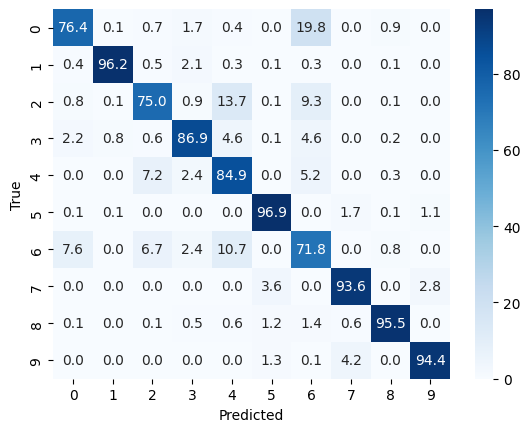

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, np.argmax(np.array(y_hat_test),axis=1))
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

Text(0, 0.5, 'Acc')

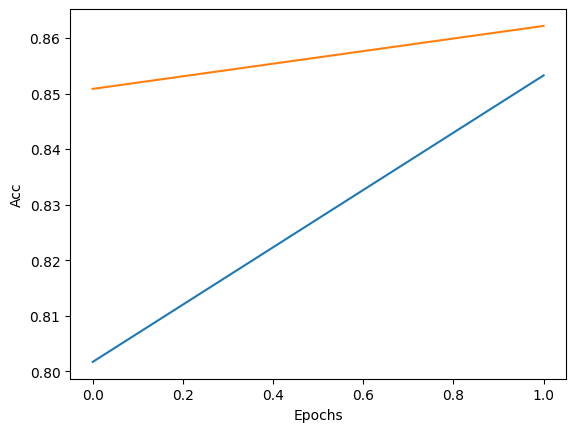

In [9]:
plt.plot(train_acc_list)
plt.plot(val_acc_list)
#plt.plot(train_loss_list)
#plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Acc")

Text(0, 0.5, 'Loss')

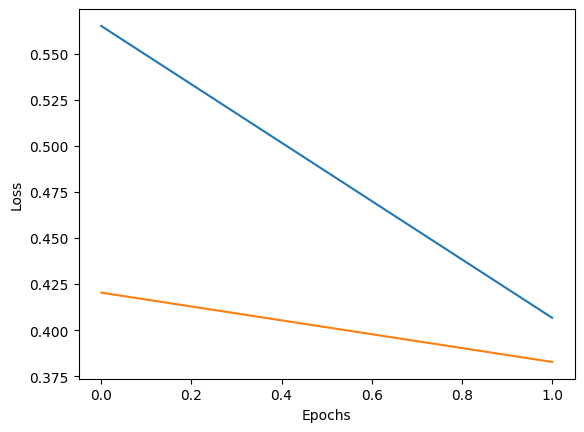

In [10]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")